In [1]:
import cv2
import numpy as np
from scipy.ndimage import sobel
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.ndimage import maximum_filter
from matplotlib import pyplot as plt

In [2]:
def compute_derivatives(image):

    img_gaussian = cv2.GaussianBlur(image, (3, 3), 0.5, borderType=cv2.BORDER_REFLECT)
    sobel_x = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
    sobel_y = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)

    return sobel_x, sobel_y

def compute_orientation(sobel_x, sobel_y):
    # Compute orientation in degrees at each pixel
    orientation = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    return orientation

In [3]:
def compute_harris_matrix(image, window_size = 5):
    # Compute x and y derivatives
    sobel_x, sobel_y = compute_derivatives(image)
    height, width = image.shape

    # print("kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd")


    # Compute Gaussian filter for weights
    gaussian_mask = gaussian_filter(np.ones((5, 5)), sigma=0.5)

    kern = cv2.getGaussianKernel(5, 0.5)

    gaussian_mask = kern*kern.T

    Ix2 = np.square(sobel_x)
    Iy2 = np.square(sobel_y)
    Ixy = sobel_x * sobel_y 

    R_matrix = np.zeros((height,width))

    window = window_size//2

    for y in range(window, height - window):
        for x in range(window, width - window):

            wIx2 = np.sum((Ix2[y - window : y + window+1, x - window : x + window+1])
                          *gaussian_mask)
            wIy2 = np.sum((Iy2[y - window : y + window+1, x - window : x + window+1])
                          *gaussian_mask)
            wIxy = np.sum((Ixy[y - window : y + window+1, x - window : x + window+1])
                          *gaussian_mask)


            M = np.array([[wIx2,wIxy],[wIxy,wIy2]])


            det = np.linalg.det(M)
            tr = np.matrix.trace(M)
            R = det - 0.05*(tr**2)
            R_matrix[y-2, x-2]=R

    return R_matrix

def find_maxima(img, R_matrix, threshold): 

    height = img.shape[0]   #.shape[0] outputs height 
    width = img.shape[1]    #.shape[1] outputs width .shape[2] outputs color channels of image

    # Normalize R_matrix
    R_matrix_normalized  = cv2.normalize(R_matrix, None, 0, 1, cv2.NORM_MINMAX)


    # Use maximum_filter to find local maxima
    thresholded_matrix_R = R_matrix_normalized  > threshold
    local_maxima = maximum_filter(thresholded_matrix_R, size=7) == thresholded_matrix_R
    
    dx, dy = compute_derivatives(img)
    orientations = compute_orientation(dx, dy)

    keypoints = []
    # Iterate over local maxima
    for y in range(2, height-2):
        for x in range(2, width-2):
            if local_maxima[y, x]:
                value = R_matrix_normalized [y, x]
                # Check if value exceeds threshold
                if value > threshold:
                    # Draw circle at local maximum
                    # cv2.circle(img, (x, y), 3, (0, 255, 0))
                    keypoints.append((x, y, orientations[y, x]))
            # print(orientations[y,x])

    # Convert OpenCV KeyPoint objects
    kp_orb = [cv2.KeyPoint(x, y, size=7, angle=orientation) for x, y, orientation in keypoints]
       
    return kp_orb


In [4]:
def HarrisPointsDetector(image, threshold= 0.83):
    if type(image) == str:
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # print("kajhkasjdhkasjdhaksjhdaskjdhaskjdhaskdjhaaksjdkasjdhaksjdhaskdjhaskdjh")

    # plt.imshow(image)
    # plt.show()

    R_matrix = compute_harris_matrix(image)
    # print(R_matrix)
    kps = find_maxima(image, R_matrix, threshold)
    return kps
    


def featureDescriptor(orb, img, kp):
    keypoints, descriptors = orb.compute(img, kp)
    return keypoints, descriptors
    

In [50]:
import numpy as np
from scipy.spatial.distance import cdist
import cv2

def SSDFeatureMatcher(descriptors1, descriptors2):
    matches = []
    distances = cdist(descriptors1, descriptors2, 'sqeuclidean')
    for i in range(len(descriptors1)):
        best_match_idx = np.argmin(distances[i])
        matches.append(cv2.DMatch(i, best_match_idx, distances[i][best_match_idx]))
    return matches

def RatioFeatureMatcher(descriptors1, descriptors2, ratio_threshold=0.7):
    matches = []
    distances = cdist(descriptors1, descriptors2, 'sqeuclidean')
    for i in range(len(descriptors1)):
        sorted_indices = np.argsort(distances[i])
        best_match_idx = sorted_indices[0]
        second_best_match_idx = sorted_indices[1]
        ratio = distances[i][best_match_idx] / distances[i][second_best_match_idx]
        if ratio < ratio_threshold:
            matches.append(cv2.DMatch(i, best_match_idx, distances[i][best_match_idx]))
    return matches

def visualize_matches(img1, keypoints1, img2, keypoints2, matches, save=False):
    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    
    # Convert BGR image to RGB (matplotlib expects RGB)
    img_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    # return img_rgb
    
    # Display the matches using plt.imshow
    plt.figure(figsize=(12,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.tight_layout

    if save:
         plt.tight_layout
         plt.savefig("matches.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [6]:
ref_img = cv2.imread('bernieSanders.jpg', cv2.IMREAD_GRAYSCALE)

ref_kp = HarrisPointsDetector(ref_img)

# print(len(kp))

# Initialize ORB detector
orb = cv2.ORB_create()

# Compute descriptors for keypoints
ref_keypoints, ref_descriptors = orb.compute(ref_img, ref_kp)

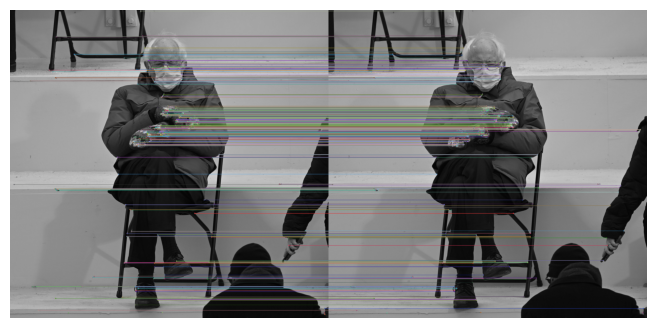

In [49]:
matches = RatioFeatureMatcher(ref_descriptors, ref_descriptors)
visualize_matches(ref_img, ref_kp, ref_img, ref_kp, matches, True)

In [24]:
img = cv2.imread('bernieMoreblurred.jpg', cv2.IMREAD_GRAYSCALE)

kp = HarrisPointsDetector(img, 0.99779)

# print(len(kp))

# Initialize ORB detector
orb = cv2.ORB_create()

# Compute descriptors for keypoints
keypoints, descriptors = orb.compute(img, kp)

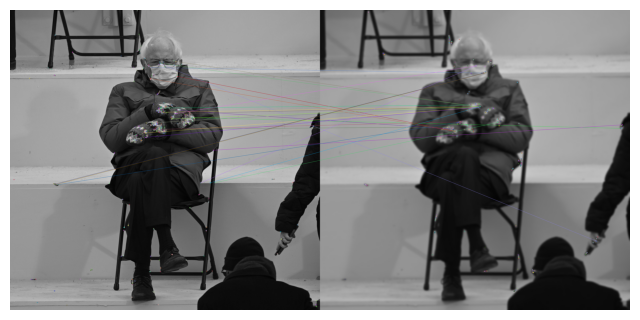

In [25]:
matches = RatioFeatureMatcher(ref_descriptors, descriptors)
visualize_matches(ref_img, ref_kp, img, kp, matches, True)

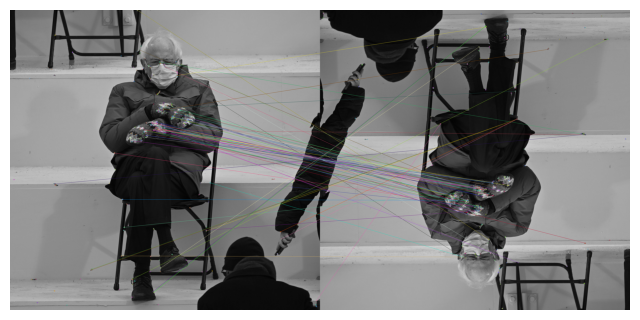

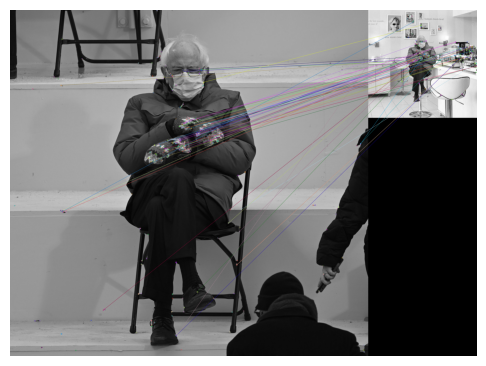

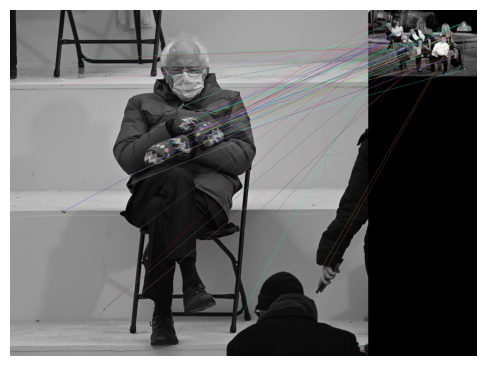

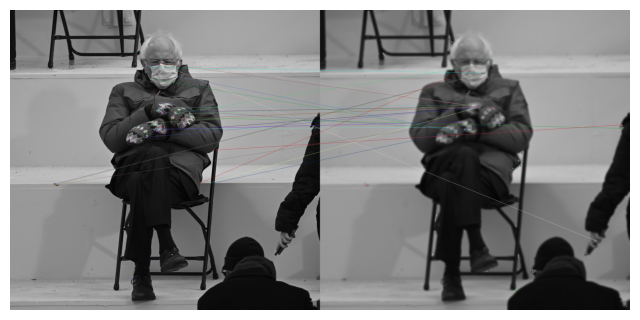

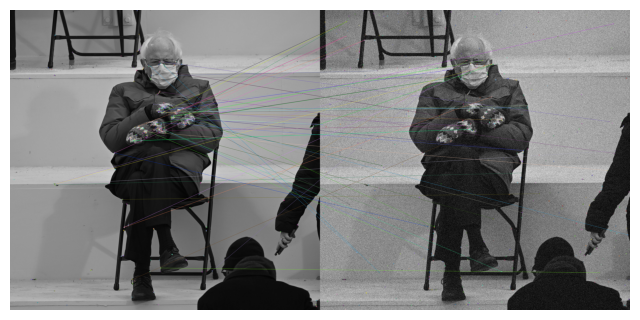

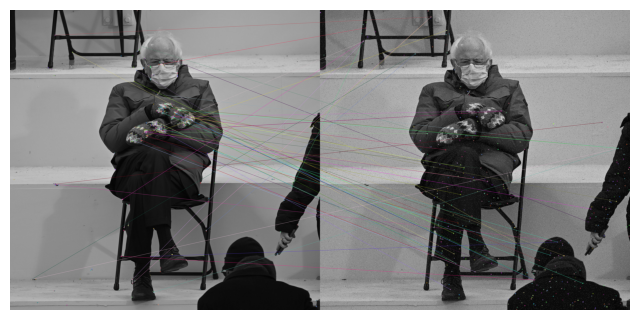

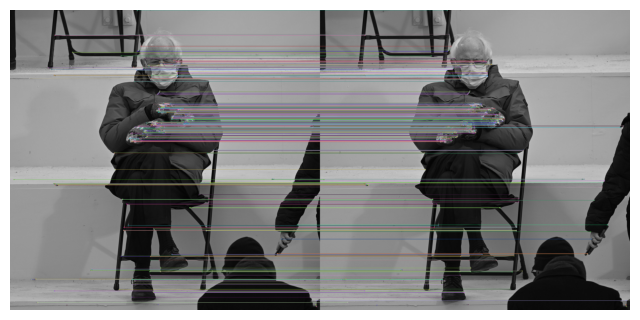

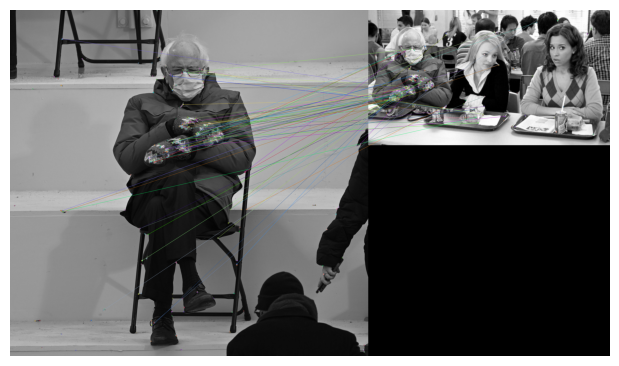

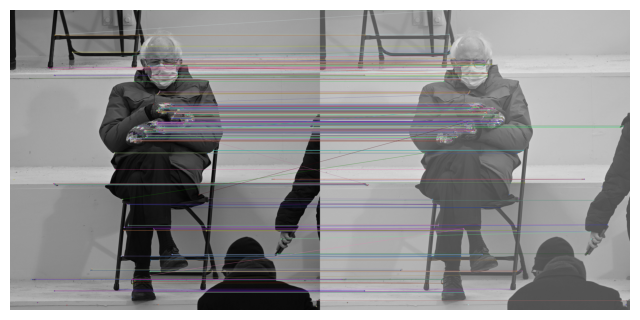

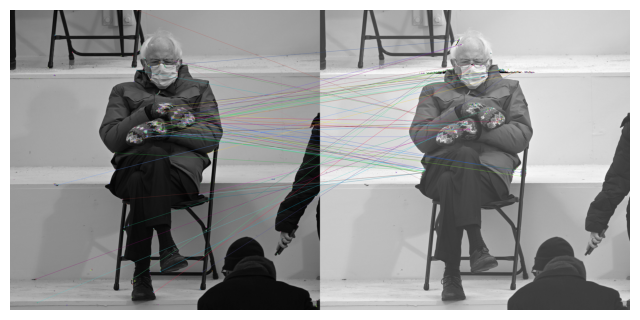

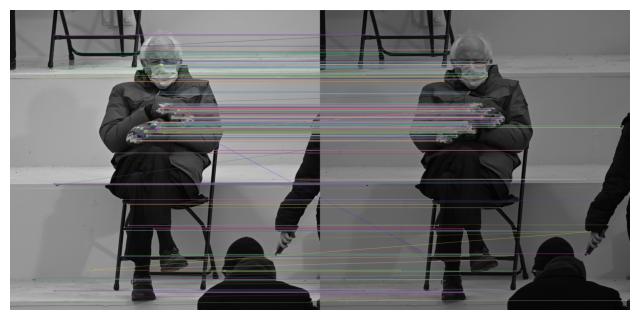

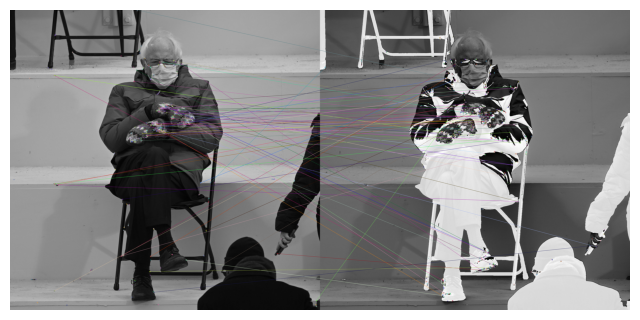

In [52]:
import os
# Path to the folder containing images
folder_path = "./imgs"
results_folder = "./testmatches"


# List all files in the folder
image_files = os.listdir(folder_path)

counter = 0
threshes = [0.83, 0.62, 0.81, 0.99779, 0.87, 0.46, 0.83, 0.885, 0.83, 0.49, 0.828, 0.63]

for filename in image_files:
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Filter image files

        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        kp = HarrisPointsDetector(img, threshes[counter])

        # Compute descriptors for keypoints
        keypoints, descriptors = orb.compute(img, kp)

        matches = RatioFeatureMatcher(ref_descriptors, descriptors)
        mat = visualize_matches(ref_img, ref_kp, img, kp, matches, True)

        plt.figure(figsize=(8,4.5))
        plt.imshow(mat)
        plt.axis('off')
        plt.savefig(os.path.join(results_folder, filename.split('.')[0] + '_matches.png'), bbox_inches='tight', pad_inches=0.1)
        plt.show()

        counter += 1